# Improving our model

Bertrand Thia (bt2513)

In this notebook, we are going to tune our previous model to improve it.

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.utils import resample

Using TensorFlow backend.


# Loading the data

In [2]:
train_labels = pd.read_csv('./train.csv')

In [3]:
train_labels['label'].value_counts()

normal       350
bacterial    350
viral        350
covid         77
Name: label, dtype: int64

In [4]:
train_labels['label'].value_counts(normalize= True)

normal       0.310559
bacterial    0.310559
viral        0.310559
covid        0.068323
Name: label, dtype: float64

As we saw in the previous notebook, our dataset is imbalanced and the number of covid cases is very low (~6% of the data). To address this issue, we will try class weigthing and oversampling later.

# Data preprocessing

### Splitting into training set and validation set 

In [5]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

### Loading the standardized data

Let's load the standardized data that we processed in the previous notebook and do some data augmentation this time to help prevent overfitting and get a more robust model:

In [6]:
train_datagen = ImageDataGenerator(shear_range= 0.2,
                                  horizontal_flip= True,
                                  rotation_range= 20,
                                  zoom_range= 0.2)

val_datagen = ImageDataGenerator()

In [7]:
X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= './train2/',
                                            x_col = 'filename',
                                            y_col = 'label',
                                            target_size= (188, 234), 
                                            batch_size= 32, 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train2/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= 32, 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are going to complexify our model to see if it can learn more:

In [8]:
bas_model = Sequential()
bas_model.add(Conv2D(32, (3, 3), input_shape= (188, 234, 1), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(32, (3, 3), activation= 'relu')) 
bas_model.add(Conv2D(32, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(64, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Flatten())
bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 64, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 4, activation= 'softmax'))

In [9]:
bas_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 186, 232, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 93, 116, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 91, 114, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 89, 112, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 44, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 54, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 27, 64)       

In [10]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(), 
                 metrics = ['accuracy'])

* ### Training 

In [11]:
epochs= 50
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 5)
#checkpoint = ModelCheckpoint("best_model.hdf5", monitor= 'val_acc', verbose= 1, save_best_only= True)

This time, we are going to use class weigthing to address the imbalance issue:

In [12]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [13]:
bas_model.fit_generator(X_train, 
                        steps_per_epoch= len(train_set) // 32, 
                        epochs= epochs, 
                        verbose= 1, 
                        validation_data = X_val, 
                        validation_steps= len(valid_set) // 32,
                        class_weight= class_weight,
                        callbacks= [es])

Epoch 1/50
28/28 [==============================] - 23s 824ms/step - loss: 4.7315 - accuracy: 0.2819 - val_loss: 1.3442 - val_accuracy: 0.4107
Epoch 2/50
28/28 [==============================] - 30s 1s/step - loss: 1.3670 - accuracy: 0.3038 - val_loss: 1.3293 - val_accuracy: 0.2938
Epoch 3/50
28/28 [==============================] - 27s 949ms/step - loss: 1.3251 - accuracy: 0.3314 - val_loss: 1.3111 - val_accuracy: 0.3711
Epoch 4/50
28/28 [==============================] - 31s 1s/step - loss: 1.3082 - accuracy: 0.3549 - val_loss: 1.2513 - val_accuracy: 0.4381
Epoch 5/50
28/28 [==============================] - 27s 950ms/step - loss: 1.2699 - accuracy: 0.3551 - val_loss: 1.2130 - val_accuracy: 0.4278
Epoch 6/50
28/28 [==============================] - 29s 1s/step - loss: 1.2506 - accuracy: 0.3843 - val_loss: 1.1828 - val_accuracy: 0.5567
Epoch 7/50
28/28 [==============================] - 29s 1s/step - loss: 1.2306 - accuracy: 0.4074 - val_loss: 1.0759 - val_accuracy: 0.5515
Epoch 8/50


### Evaluating the model

In [14]:
evaluation = bas_model.evaluate_generator(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.717


In [15]:
# Loading the validation set without shuffle to compare manually 
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train2/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= len(valid_set), 
                                        color_mode= 'grayscale',
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [16]:
pred = bas_model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([3, 2, 0, 0, 2, 2, 0, 0, 3, 0])

In [17]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [18]:
y_val = valid_set['label'].map(X_val.class_indices).values

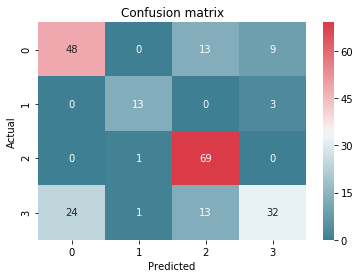

In [19]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [20]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        70
           1       0.87      0.81      0.84        16
           2       0.73      0.99      0.84        70
           3       0.73      0.46      0.56        70

    accuracy                           0.72       226
   macro avg       0.75      0.74      0.73       226
weighted avg       0.72      0.72      0.70       226



**The performances are much better than previously. Let's keep working to improve furthermore our model.**

# Predicting on the test set

In [23]:
test_df = pd.read_csv('test.csv')

In [24]:
test_datagen = ImageDataGenerator()
X_test = test_datagen.flow_from_directory('./test2',
                                           classes = ['test'],
                                           target_size= (188, 234), 
                                           batch_size= len(test_df), 
                                           color_mode= 'grayscale',
                                           shuffle= False)

Found 484 images belonging to 1 classes.


In [25]:
pred = bas_model.predict_generator(X_test)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 2, 2, 2, 2, 2, 2, 2, 0, 2])

### Formatting the output like the submission example

In [26]:
submission = pd.read_csv('submission.csv')
submission.head()

,Id,label
0,0,bacterial
1,1,viral
2,2,normal
3,3,normal
4,4,bacterial


In [34]:
data = {'Id': test_df['id'], 'label': y_pred}
output = pd.DataFrame(data)
output['label'] = output['label'].map({0:'bacterial', 1: 'covid', 2: 'normal', 3: 'viral'})
output.head()

,Id,label
0,0,bacterial
1,1,normal
2,2,normal
3,3,normal
4,4,normal


In [35]:
# saving the output
output.to_csv('output_v0.csv')

---

# Appendix

In [21]:
# Computing the accuracy manually to check 
(df['y_val'] == df['y_pred']).sum() / len(df)

0.7168141592920354